In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
data = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
data.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
rename = {
    "preco": "price",
    "vendido": "sold",
    "idade_do_modelo": "model_age",
    "km_por_ano": "km_per_year"
}

data = data.rename(columns=rename)
data.head()

,price,sold,model_age,km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
# horribly unlucky situation where the classes are ordered by default

data_unluck = data.sort_values("sold", ascending=True)
x_unluck = data_unluck[["price", "model_age", "km_per_year"]]
y_unluck = data_unluck["sold"]
data_unluck.head()

,price,sold,model_age,km_per_year
10,75668.42,0,2,22635.36710
7,65265.09,0,10,18666.73466
3,95276.14,0,3,43167.32682
2,89627.50,0,12,11440.79806
4221,64724.65,0,10,13194.97866


In [4]:
from sklearn.model_selection import cross_validate
from  sklearn.dummy  import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

model = DummyClassifier(strategy="stratified")
results = cross_validate(model, x_unluck, y_unluck, cv=10, return_train_score=False)
mean = results["test_score"].mean()
std = results["test_score"].std()
print(f"Accuracy with cross-validation, 10 = [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

Accuracy with cross-validation, 10 = [49.79, 53.45]


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED  = 301
np.random.seed(SEED)

model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(model, x_unluck, y_unluck, cv=10, return_train_score=False)
mean = results["test_score"].mean()
std = results["test_score"].std()
print(f"Accuracy with cross-validation, 10 = [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

Accuracy with cross-validation, 10 = [73.26, 78.30]


In [6]:
# Generating random car model data for clustering simulation using our estimator

np.random.seed(SEED)
data["model"] = data.model_age + np.random.randint(-2, 3, size=10000)
data.model = data.model + abs(data.model.min()) + 1
data.head()

,price,sold,model_age,km_per_year,model
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [7]:
def print_results(results):
    mean = results["test_score"].mean()
    std = results["test_score"].std()
    print(f"Mean accuracy: {mean*100:.2f}")
    print(f"Accuracy interval: [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

In [8]:
# GroupKFold to analyze how the model behaves with new groups

from sklearn.model_selection import GroupKFold

SEED  = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 75.79
Accuracy interval: [74.03, 77.56]


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED  = 301
np.random.seed(SEED)

scaler = StandardScaler()
model = SVC()

pipeline = Pipeline([('transformation',scaler), ('estimator', model)])

cv = GroupKFold(n_splits=10)
results = cross_validate(pipeline, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 76.62
Accuracy interval: [74.02, 79.22]


In [13]:
# GroupKFold to analyze how the model behaves with new groups

from sklearn.model_selection import GroupKFold

SEED  = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
model = DecisionTreeClassifier(max_depth=3)
results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 78.66
Accuracy interval: [77.21, 80.12]


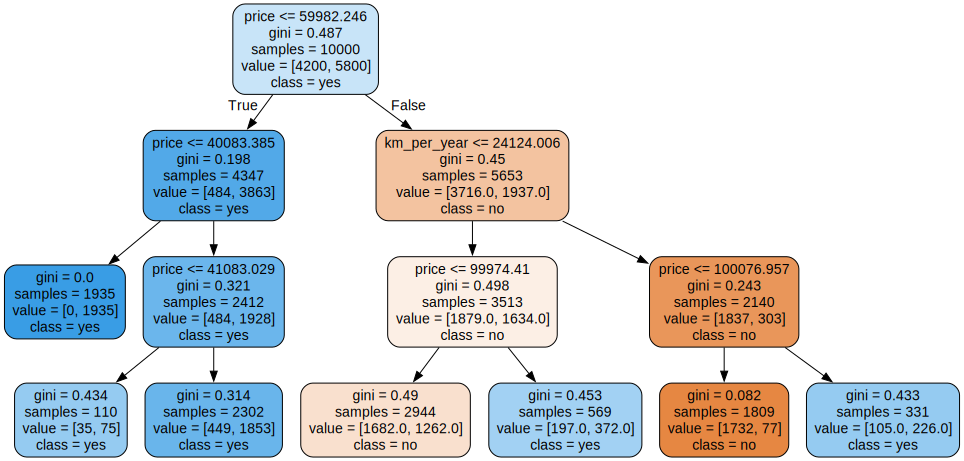

In [14]:
from sklearn.tree import export_graphviz
import graphviz

model.fit(x_unluck, y_unluck)
features = x_unluck.columns
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True, class_names=["no", "yes"], feature_names=features)
graph = graphviz.Source(dot_data)
graph